# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
import seaborn as sns

In [2]:
# seed hold

random_seed = 42
SEED = 42
np.random.seed(random_seed)
import os
import random

import tensorflow as tf

random.seed(random_seed)


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        logging.warning(
            "*******************************************************************************"
        )
        logging.warning(
            "*** set_global_determinism is called,setting full determinism, will be slow ***"
        )
        logging.warning(
            "*******************************************************************************"
        )
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Preprocess

## Load data

In [3]:
l1 = pd.read_csv('1_left.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
r1 = pd.read_csv('1_right.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
l2 = pd.read_csv('2_left.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)
r2 = pd.read_csv('2_right.csv', index_col=0, parse_dates=['time'], infer_datetime_format=True)

In [4]:
# 시간 정렬

l1.sort_values(by='time', inplace=True)
r1.sort_values(by='time', inplace=True)
l2.sort_values(by='time', inplace=True)
r2.sort_values(by='time', inplace=True)

In [5]:
r1.head()

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
15288,PLASMA W/D 2호기,335,2021-01-01,MEVERICK (RWD/FWD),53.3,23.71,7.31,7.0,GOOD,18088,74,2021-01-01 08:33:33
15287,PLASMA W/D 2호기,336,2021-01-01,MEVERICK (RWD/FWD),53.3,23.51,7.30,7.0,GOOD,18089,74,2021-01-01 08:33:52
15286,PLASMA W/D 2호기,337,2021-01-01,MEVERICK (RWD/FWD),53.3,23.47,7.31,7.0,GOOD,18090,74,2021-01-01 08:34:16
15285,PLASMA W/D 2호기,338,2021-01-01,MEVERICK (RWD/FWD),53.3,23.46,7.31,7.0,GOOD,18091,74,2021-01-01 08:34:30
15284,PLASMA W/D 2호기,339,2021-01-01,MEVERICK (RWD/FWD),53.3,23.44,7.31,7.0,GOOD,18092,74,2021-01-01 08:34:46


In [6]:
r1.reset_index(inplace=True, drop=True)

In [7]:
r1['공정명'].value_counts()

PLASMA W/D 1호기    402841
PLASMA W/D 2호기     34529
Name: 공정명, dtype: int64

In [8]:
r1[r1['공정명'] == 'PLASMA W/D 2호기']

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
0,PLASMA W/D 2호기,335,2021-01-01,MEVERICK (RWD/FWD),53.3,23.71,7.31,7.0,GOOD,18088,74,2021-01-01 08:33:33
1,PLASMA W/D 2호기,336,2021-01-01,MEVERICK (RWD/FWD),53.3,23.51,7.30,7.0,GOOD,18089,74,2021-01-01 08:33:52
2,PLASMA W/D 2호기,337,2021-01-01,MEVERICK (RWD/FWD),53.3,23.47,7.31,7.0,GOOD,18090,74,2021-01-01 08:34:16
3,PLASMA W/D 2호기,338,2021-01-01,MEVERICK (RWD/FWD),53.3,23.46,7.31,7.0,GOOD,18091,74,2021-01-01 08:34:30
4,PLASMA W/D 2호기,339,2021-01-01,MEVERICK (RWD/FWD),53.3,23.44,7.31,7.0,GOOD,18092,74,2021-01-01 08:34:46
...,...,...,...,...,...,...,...,...,...,...,...,...
34524,PLASMA W/D 2호기,447,2021-02-04,MEVERICK (RWD/FWD),49.3,22.13,6.11,7.0,GOOD,3906,74,2021-02-04 11:07:50
34525,PLASMA W/D 2호기,448,2021-02-04,MEVERICK (RWD/FWD),49.3,22.17,6.10,7.0,GOOD,3907,74,2021-02-04 11:08:06
34526,PLASMA W/D 2호기,449,2021-02-04,MEVERICK (RWD/FWD),49.3,22.13,6.11,7.0,GOOD,3908,74,2021-02-04 11:08:20
34527,PLASMA W/D 2호기,450,2021-02-04,MEVERICK (RWD/FWD),49.3,22.17,6.11,7.0,GOOD,3909,74,2021-02-04 11:08:36


In [9]:
r1[r1['date'] == '2021-04-01']

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
87727,PLASMA W/D 1호기,1,2021-04-01,MEVERICK (RWD/FWD),48.3,23.44,5.74,7.2,GOOD,9765,76,2021-04-01 08:30:55
87728,PLASMA W/D 1호기,2,2021-04-01,MEVERICK (RWD/FWD),48.3,23.46,5.71,7.2,GOOD,9766,76,2021-04-01 08:33:51
87729,PLASMA W/D 1호기,3,2021-04-01,MEVERICK (RWD/FWD),48.3,23.24,5.70,7.2,GOOD,9767,76,2021-04-01 08:34:08
87730,PLASMA W/D 1호기,4,2021-04-01,MEVERICK (RWD/FWD),48.2,23.33,5.71,7.2,GOOD,9768,76,2021-04-01 08:34:24
87731,PLASMA W/D 1호기,5,2021-04-01,MEVERICK (RWD/FWD),48.3,23.12,5.72,7.2,GOOD,9769,76,2021-04-01 08:34:40
...,...,...,...,...,...,...,...,...,...,...,...,...
89370,PLASMA W/D 1호기,347,2021-04-01,MEVERICK (RWD/FWD),50.4,21.23,5.23,7.1,GOOD,11408,75,2021-04-01 19:46:07
89371,PLASMA W/D 1호기,348,2021-04-01,MEVERICK (RWD/FWD),50.4,21.27,5.22,7.2,GOOD,11409,76,2021-04-01 19:46:27
89372,PLASMA W/D 1호기,349,2021-04-01,MEVERICK (RWD/FWD),50.4,21.31,5.22,7.2,GOOD,11410,76,2021-04-01 19:46:44
89373,PLASMA W/D 1호기,350,2021-04-01,MEVERICK (RWD/FWD),50.3,21.27,5.23,7.2,GOOD,11411,76,2021-04-01 19:46:59


In [10]:
# 1호기 left와 날짜를 맞추기 위해 4월 1일 전까지 drop
r1 = r1[87727:]
r1.reset_index(drop=True, inplace=True)

# X, y make
y = r1['estimate']
X = r1.drop(['공정명', 'date', 'model_name', 'NUM(EA)', 'time', 'estimate'], axis=1)

In [11]:
print(X.shape)
print(y.shape)

(349643, 6)
(349643,)


## train test split

In [12]:
r1[r1['date'] == '2021-12-06']

,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time
252607,PLASMA W/D 1호기,1,2021-12-06,MEVERICK (RWD/FWD),53.4,21.51,8.12,6.6,GOOD,45611,70,2021-12-06 08:33:16
252608,PLASMA W/D 1호기,2,2021-12-06,MEVERICK (RWD/FWD),53.4,21.42,8.14,6.6,GOOD,45612,70,2021-12-06 08:33:41
252609,PLASMA W/D 1호기,3,2021-12-06,MEVERICK (RWD/FWD),53.4,21.42,8.14,6.6,GOOD,45613,70,2021-12-06 08:34:33
252610,PLASMA W/D 1호기,4,2021-12-06,MEVERICK (RWD/FWD),53.3,21.54,8.13,6.5,GOOD,45614,69,2021-12-06 08:37:19
252611,PLASMA W/D 1호기,5,2021-12-06,MEVERICK (RWD/FWD),53.3,21.51,8.15,6.6,GOOD,45615,70,2021-12-06 08:37:40
...,...,...,...,...,...,...,...,...,...,...,...,...
254302,PLASMA W/D 1호기,5,2021-12-06,MEVERICK (RWD/FWD),52.0,24.76,7.70,6.6,GOOD,47306,70,2021-12-06 19:57:31
254303,PLASMA W/D 1호기,6,2021-12-06,MEVERICK (RWD/FWD),52.0,25.12,7.72,6.6,GOOD,47307,70,2021-12-06 20:00:47
254304,PLASMA W/D 1호기,7,2021-12-06,MEVERICK (RWD/FWD),52.0,25.08,7.73,6.6,GOOD,47308,70,2021-12-06 20:01:38
254305,PLASMA W/D 1호기,8,2021-12-06,MEVERICK (RWD/FWD),50.9,25.04,7.73,6.6,GOOD,47309,70,2021-12-06 20:04:23


In [13]:
# 12월 6일 기준 split
X_train= X[:252607]
y_train= y[:252607]
X_test= X[252607:]
y_train= y[252607:]

## Transform to sequence

In [14]:
step = 10

def trans_sequences(df, step):
    temp = []
    for i in range(len(df)-step+1):
        temp.append(df.iloc[i:(i+step)].values)
    
    return np.array(temp)

In [15]:
train_seq = trans_sequences(X_train, step)
test_seq = trans_sequences(X_test, step)

print(f'Training shape: {train_seq.shape}')
print(f'Testing shape: {test_seq.shape}')

Training shape: (252598, 10, 6)
Testing shape: (97027, 10, 6)


## feature scaling

In [16]:
train_seq_for_scale = train_seq.copy()
test_seq_for_scale = test_seq.copy()

train_number = train_seq_for_scale.shape[0]
feature_number = train_seq_for_scale.shape[2]
test_number = test_seq_for_scale.shape[0]

In [17]:
scaler = StandardScaler()

for i in range(step):
    scaler.partial_fit(train_seq_for_scale[:, i, :])

In [18]:
def scale(df, rows):
    scaled_array = []
    
    for i in range(step):
        scaled_array.append(scaler.transform(df[:, i, :]).reshape(rows, 1, feature_number))
    
    return np.concatenate(scaled_array, axis=1)

In [19]:
train_scaled = scale(train_seq_for_scale, train_number)
test_scaled = scale(test_seq_for_scale, test_number)

# Modeling

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 6)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            4992      
                                                                 
 dropout_4 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 16)           0         
 or)                                                             
                                                           

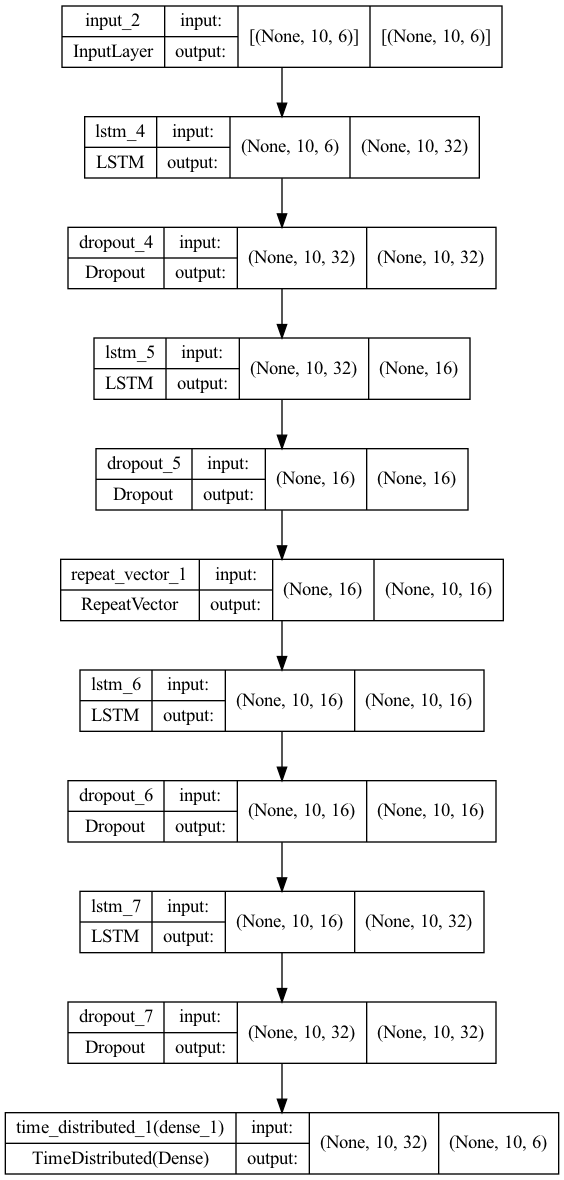

In [21]:
# encoder
pre_input = Input(shape=(step,feature_number))
encoder = LSTM(32, activation='swish', return_sequences=True)(pre_input)
encoder = Dropout(.1)(encoder)
encoder = LSTM(16, activation='swish', return_sequences=False)(encoder)
encoder = Dropout(.1)(encoder)

# reconstruct decoder
decoder1 = RepeatVector(step)(encoder)
decoder1 = LSTM(16, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = LSTM(32, activation='swish', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = TimeDistributed(Dense(feature_number))(decoder1)

# tie
lstm_autoencoder = Model(inputs=pre_input, outputs=decoder1)
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mse')
plot_model(lstm_autoencoder, show_shapes=True)

In [22]:
# set parameter
epochs = 10
batch_size = 256
validation_split = 0.2
earlystop_patience = 2

In [23]:
# fit
history = lstm_autoencoder.fit(train_scaled, train_scaled, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, mode='min')], shuffle=False)

Epoch 1/10


2022-05-19 09:43:23.360652: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 09:43:24.372663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - ETA: 0s - loss: 0.7567

2022-05-19 09:52:13.942657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 542s 683ms/step - loss: 0.7567 - val_loss: 1.3251
Epoch 2/10
790/790 [==============================] - 593s 750ms/step - loss: 0.5360 - val_loss: 1.3542
Epoch 3/10
790/790 [==============================] - 563s 713ms/step - loss: 0.4217 - val_loss: 1.2591
Epoch 4/10
790/790 [==============================] - 576s 729ms/step - loss: 0.3411 - val_loss: 1.2376
Epoch 5/10
790/790 [==============================] - 529s 670ms/step - loss: 0.2785 - val_loss: 1.1781
Epoch 6/10
790/790 [==============================] - 525s 665ms/step - loss: 0.2423 - val_loss: 1.1020
Epoch 7/10
790/790 [==============================] - 546s 691ms/step - loss: 0.2133 - val_loss: 1.0004
Epoch 8/10
790/790 [==============================] - 510s 645ms/step - loss: 0.1977 - val_loss: 0.9489
Epoch 9/10
790/790 [==============================] - 509s 644ms/step - loss: 0.1837 - val_loss: 0.9446
Epoch 10/10
790/790 [==============================] - 516s 653ms/step - lo

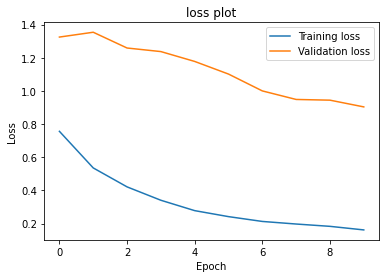

In [24]:
# loss plot
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [25]:
# predict
train_predict = lstm_autoencoder.predict(train_scaled)

2022-05-19 13:09:48.154387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [26]:
# anormaly
mse = np.mean(np.power(np.mean(train_predict-train_scaled, axis=1), 2), axis=1)
rmse = np.sqrt(np.mean(np.power(np.mean(train_predict-train_scaled, axis=1), 2), axis=1))

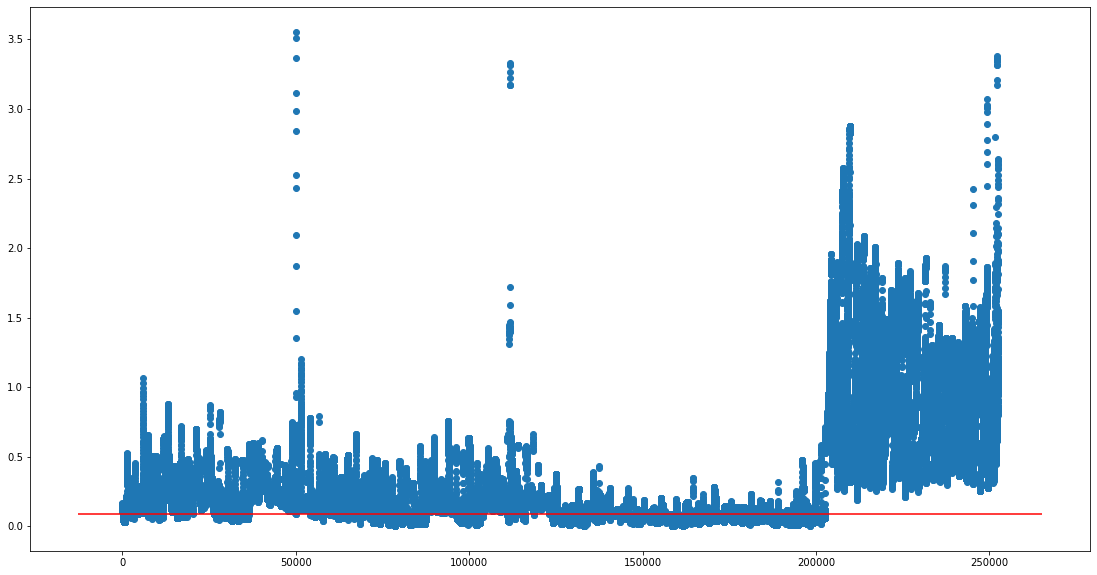

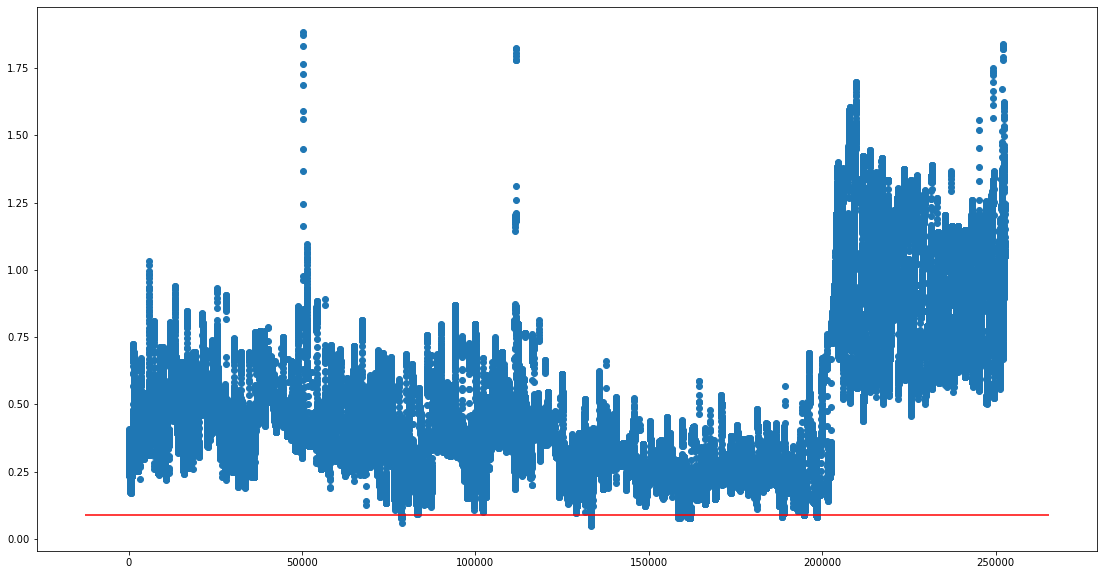

In [105]:
# set threshold & plot
threshold = 0.09

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(mse).index, mse)
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(rmse).index, rmse)
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

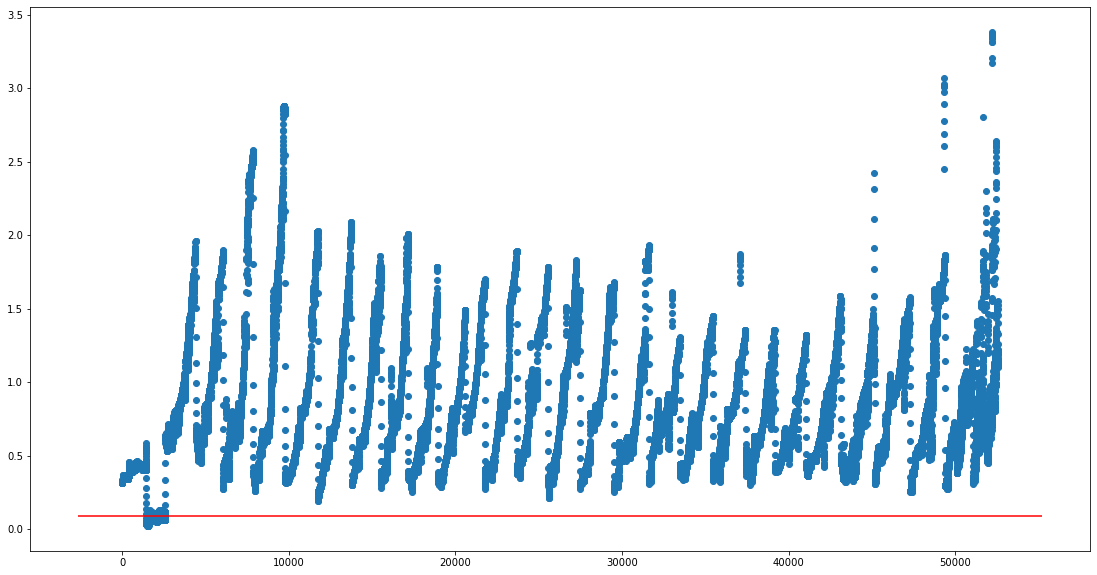

In [106]:
plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(mse[200000:]).index, mse[200000:])
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

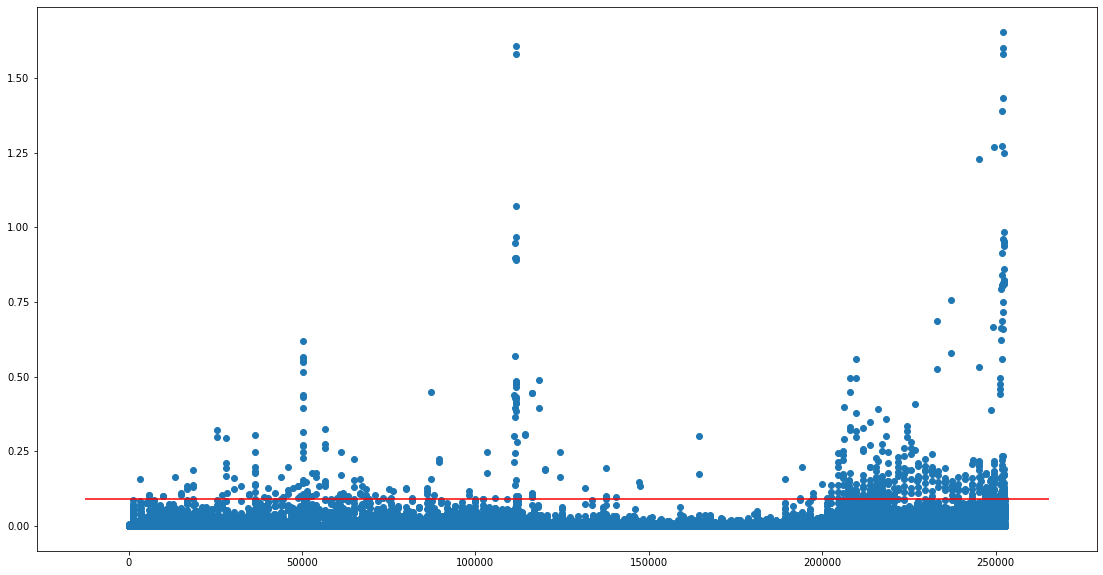

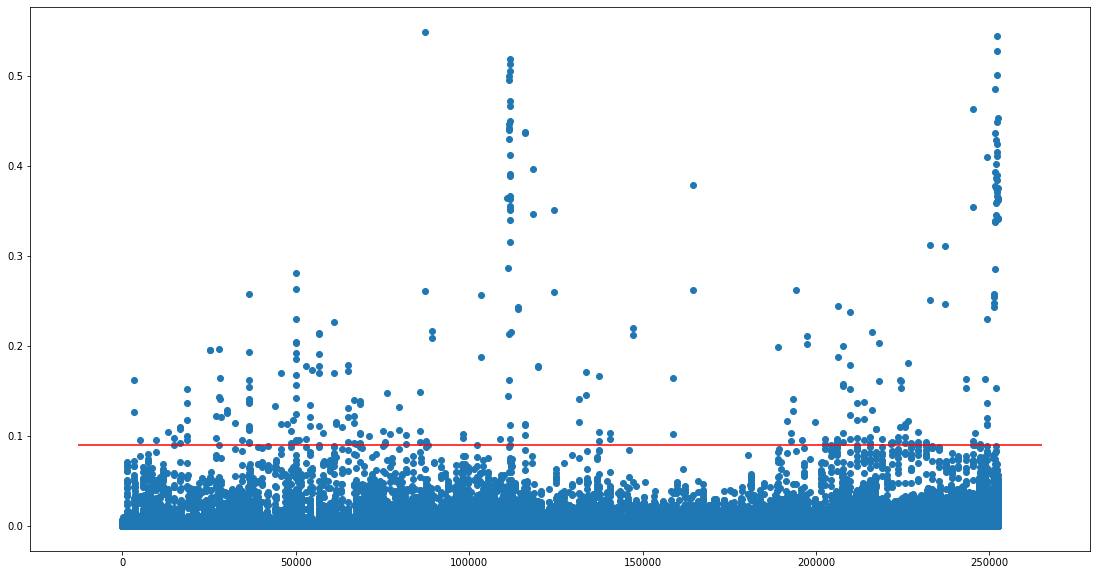

In [107]:
# set threshold & plot
plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(mse).index, np.abs(pd.DataFrame(mse).diff()))
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

plt.figure(figsize=(19,10))
plt.scatter(pd.DataFrame(rmse).index, np.abs(pd.DataFrame(rmse).diff()))
ax = plt.subplot()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

In [108]:
# match anormaly flat
rmse_anormaly = list((np.abs(pd.DataFrame(rmse).diff()) > threshold)[0])
mse_anormaly = list((np.abs(pd.DataFrame(mse).diff()) > threshold)[0])

for _ in range(step - 1):
    rmse_anormaly.insert(0, rmse_anormaly[0])
    mse_anormaly.insert(0, mse_anormaly[0])

print(len(rmse_anormaly))
print(len(mse_anormaly))
print(X_train.shape)

252607
252607
(252607, 6)


In [109]:
# make check table
check_right = r1[:len(X_train)]
check_right['rmse_anormaly'] = rmse_anormaly
check_right['mse_anormaly'] = mse_anormaly
check_right.head()

/var/folders/qd/yc_92c9d2csclp39hh5l_t900000gn/T/ipykernel_9210/1389927438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_right['rmse_anormaly'] = rmse_anormaly
/var/folders/qd/yc_92c9d2csclp39hh5l_t900000gn/T/ipykernel_9210/1389927438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_right['mse_anormaly'] = mse_anormaly


,공정명,product,date,model_name,A,V,G,T,estimate,tip_cum,NUM(EA),time,rmse_anormaly,mse_anormaly
0,PLASMA W/D 1호기,1,2021-04-01,MEVERICK (RWD/FWD),48.3,23.44,5.74,7.2,GOOD,9765,76,2021-04-01 08:30:55,False,False
1,PLASMA W/D 1호기,2,2021-04-01,MEVERICK (RWD/FWD),48.3,23.46,5.71,7.2,GOOD,9766,76,2021-04-01 08:33:51,False,False
2,PLASMA W/D 1호기,3,2021-04-01,MEVERICK (RWD/FWD),48.3,23.24,5.70,7.2,GOOD,9767,76,2021-04-01 08:34:08,False,False
3,PLASMA W/D 1호기,4,2021-04-01,MEVERICK (RWD/FWD),48.2,23.33,5.71,7.2,GOOD,9768,76,2021-04-01 08:34:24,False,False
4,PLASMA W/D 1호기,5,2021-04-01,MEVERICK (RWD/FWD),48.3,23.12,5.72,7.2,GOOD,9769,76,2021-04-01 08:34:40,False,False


In [110]:
error_num = check_right.groupby(by='date')['rmse_anormaly'].sum().reset_index()
error_num[error_num['date'] == '2021-04-07']

,date,rmse_anormaly
6,2021-04-07,1
